In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import requests 
from urllib.parse import urlencode 
import pandahouse as ph

import pingouin as pg
import scipy.stats as ss

%matplotlib inline

## Задание 1. A/B–тестирование

В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. Необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

**Входные данные**

В качестве входных данных вы имеете 4 csv-файла:

- groups.csv – файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
- groups_add.csv – дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
- active_studs.csv – файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
- checks.csv – файл с информацией об оплатах пользователей в дни проведения эксперимента.  

In [2]:
# Считать файл через api
def read_yandex_disk(public_key, sep=','):
    """
    Функция считывает данные через api
    Входные данные:
    public_key - Ссылка на файл
    sep - Символ, который используется в качестве разделителя
    """
    # используем api 
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 

    # получаем url 
    final_url = base_url + urlencode(dict(public_key=public_key)) 
    response = requests.get(final_url) 
    download_url = response.json()['href'] 

    # загружаем файл в df 
    download_response = requests.get(download_url) 
    df = pd.read_csv(download_url, sep=sep) 
    return df

In [3]:
df_groups = read_yandex_disk('https://disk.yandex.ru/d/UhyYx41rTt3clQ', ';')
df_groups_add = read_yandex_disk('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ')
df_active_studs = read_yandex_disk('https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ')
df_checks = read_yandex_disk('https://disk.yandex.ru/d/pH1q-VqcxXjsVA', ';')


/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


### Предварительный анализ данных:
1. Проверить есть ли дубликаты в данных
2. Какая группа больше?
3. Вид распределения транзакций
4. Сформировать таблицу со следующими данными:
    - student_id
    - grp
    - rev
    - open_web - открывал ли сайт пользователь
    - made_purchase - сделал ли покупку
5. Есть ли аномалии в данных
6. Исключить аномалии из данных

### df_groups
Подробно изучим данные из датасета groups.csv

Общее число записей

In [4]:
df_groups.shape

(74484, 2)

Проверим распределение студентов по группам

In [5]:
df_groups.groupby("grp", as_index=False)\
    .agg({'id': 'count'})

,grp,id
0,A,14671
1,B,59813


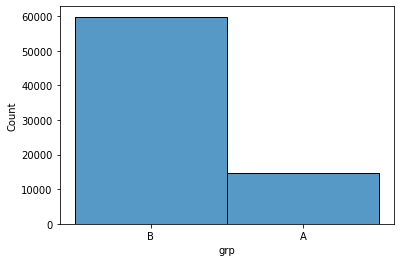

In [6]:
sns.histplot(x='grp', data=df_groups)

Распределение пользователей по группам **не равномерно**

Сколько пользователей приобрели наш продукт?

In [7]:
df_1 = pd.merge(df_groups, df_checks, left_on='id', right_on='student_id', how='left')
df_1.groupby(['grp'], as_index=False)\
    .agg({'rev':'count'})

,grp,rev
0,A,107
1,B,433


### Выводы из исследования df_groups:
1. В таблице **df_groups** приведены данные о том, в какую группу попал пользователь (id - идентификационный номер пользователя, grp - группа, в которую попал пользователь в период проведения эксперимента: А - контрольная, В - экспериментальная). 
2. Явно видно, что в экспериментальную группу попало больше пользователей, чем в контрольную. 
3. Общее число пользователей - 74 484, купили продукт - 540.

### df_groups_add
Перейдем к данным из датасета df_groups_add.csv

Общее число записей

In [8]:
df_groups_add.shape

(92, 2)

Проверим распределение студентов по группам

In [9]:
df_groups_add.groupby("grp", as_index=False)\
    .agg({'id': 'count'})

,grp,id
0,A,22
1,B,70


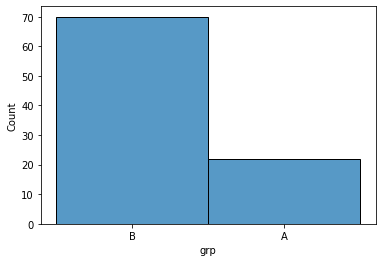

In [10]:
sns.histplot(x='grp', data=df_groups_add)

Как и в первом датасете распределение пользователей по группам **не равномерно**

Сколько пользователей приобрели наш продукт?

In [11]:
df_2 = pd.merge(df_groups_add, df_checks, left_on='id', right_on='student_id', how='left')

In [12]:
df_2.groupby(['grp'], as_index=False)\
    .agg({'rev':'count'})

,grp,rev
0,A,0
1,B,1


### Выводы из исследования df_groups_add:
1. В таблице **df_groups_add** представлены данные о принадлежности пользователя к группе (id — идентификационный номер пользователя, grp — группа, в которую попал пользователь в период проведения эксперимента: А — контрольная, В — экспериментальная). 
2. Также видно, что в экспериментальную группу попало больше пользователей, чем в контрольную. 
3. Общее число пользователей - 92, купил продукт - 1.

### Объединим датасеты df_groups_add и df_groups 
Проверим:
- есть ли дубликаты в данных 
- корректность сплит-системы

In [13]:
df_groups_all = df_groups.append(df_groups_add, ignore_index=True)

In [14]:
df_groups_all.shape

(74576, 2)

In [15]:
if df_groups_all.duplicated().sum() > 0:
    print('Дубликаты обнаружены')
else:
    print('Нет дубликатов')

Нет дубликатов


In [16]:
group_a = set(df_groups_all.query("grp == 'A'").id)
group_b = set(df_groups_all.query("grp == 'B'").id)

group_a.intersection(group_b)

set()

Сплит-система работает корректно. Пользователи, которые попали в контрольную группу не появились в экспериментальной и наоборот

### active_studs
Изучим данные из файла active_studs.csv

In [17]:
df_active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [18]:
df_active_studs.shape

(8341, 1)

In [19]:
if df_active_studs.duplicated().sum() > 0:
    print('Дубликаты обнаружены')
else:
    print('Нет дубликатов')

Нет дубликатов


In [20]:
df_active_studs['open_web'] = [1] * df_active_studs.shape[0]

### Вывод из исследования active_studs:
1. В данном датасете представлены id студентов, которые заходили на платформу в период проведения эксперимента
2. Дубликаты не были обнаружены
3. В дни проведения эксперимента только 8 341 студента посетили сайт

### df_checks
Исследуем последний датафрейм 
1. Найдем общее количество транзакций
2. Проверим есть ли дубликаты в данных
3. Построим распределение суммы покупки 

In [21]:
df_checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [22]:
df_checks.shape

(541, 2)

Text(0, 0.5, '')

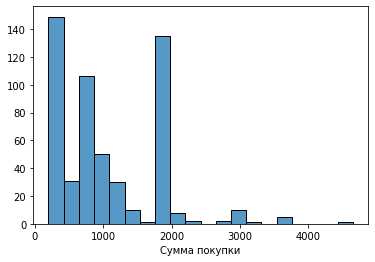

In [23]:
ax = sns.histplot(data=df_checks, x='rev', bins=20)
plt.xlabel("Сумма покупки")
plt.ylabel("")

In [24]:
if df_checks.duplicated().sum() > 0:
    print('Дубликаты обнаружены')
else:
    print('Нет дубликатов')

Нет дубликатов


In [25]:
df_checks.describe()

,student_id,rev
count,5.410000e+02,541.000000
mean,2.514772e+06,1059.752317
std,1.726839e+06,762.712359
min,1.627000e+03,199.000000
25%,9.871290e+05,290.000000
50%,2.526021e+06,840.000000
75%,3.993249e+06,1900.000000
max,5.740903e+06,4650.000000


In [26]:
df_checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


### Вывод из исследования df_checks:
1. В данном датасете представлены id студентов, которые купили наш продукт и выручка 
2. Дубликаты не были обнаружены
3. В дни проведения эксперимента оплата была произведена 541 раз

### Составим общий датасет df_revenue_all

In [27]:
df_revenue_all = pd.merge(df_groups_all, df_checks, left_on='id', right_on='student_id', how='left')\
    .drop(columns='student_id', axis=1).rename(columns={'id':'student_id'})
df_revenue_all = df_revenue_all.merge(df_active_studs, on='student_id', how='left')
df_revenue_all['made_purchase'] = df_revenue_all.rev.apply(lambda x: 1 if x > 0 else 0)
df_revenue_all.open_web = df_revenue_all.open_web.fillna(0).astype(int)
df_revenue_all.shape

(74576, 5)

Проведем поиск аномалий в данных

In [28]:
# количество студентов в разных когортах
df_revenue_all.groupby(['grp', 'open_web', 'made_purchase'], as_index=False)\
    .agg({'student_id': 'count'})

,grp,open_web,made_purchase,student_id
0,A,0,0,13126
1,A,0,1,29
2,A,1,0,1460
3,A,1,1,78
4,B,0,0,52960
5,B,0,1,120
6,B,1,0,6489
7,B,1,1,314


In [29]:
# Общее часло клиентов, которые совершили покупку 
df_revenue_all.query("made_purchase == 1")\
    .groupby('grp', as_index=False)\
    .agg({'open_web':'count'})

,grp,open_web
0,A,107
1,B,434


In [30]:
# Студенты, которые посетили сайт
df_revenue_all.groupby('grp', as_index=False)\
    .agg({'open_web':'sum'})

,grp,open_web
0,A,1538
1,B,6803


In [31]:
# Общее число студентов в группах
df_revenue_all.groupby('grp', as_index=False)\
    .agg({'student_id':'count'})

,grp,student_id
0,A,14693
1,B,59883


Распределение 

Text(0, 0.5, '')

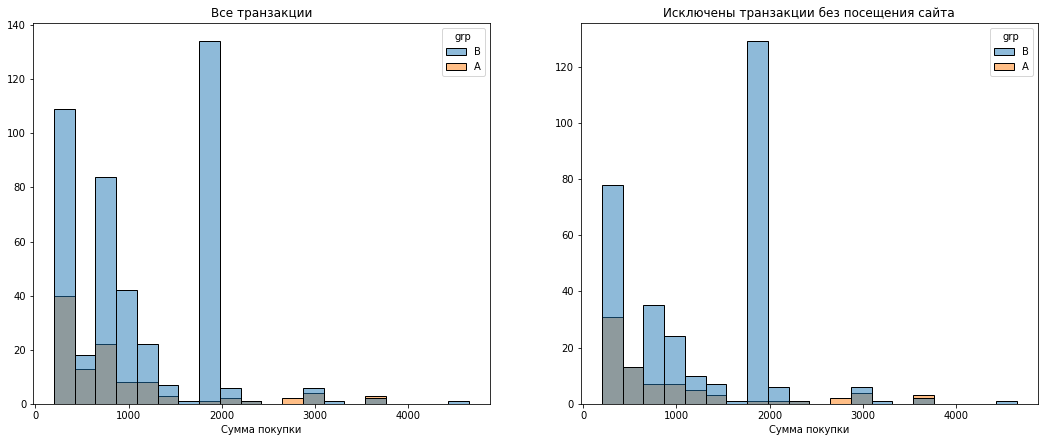

In [32]:
fig = plt.figure(figsize=(18, 7))

plt.subplot(1, 2, 1)
sns.histplot(data=df_revenue_all, x='rev', 
             bins=20, hue='grp')
plt.xlabel("Сумма покупки")
plt.title("Все транзакции")
plt.ylabel("")

plt.subplot(1, 2, 2)
sns.histplot(data=df_revenue_all.query("~ (made_purchase == 1 and open_web == 0)"), 
             x='rev', 
             bins=20, hue='grp')
plt.xlabel("Сумма покупки")
plt.title("Исключены транзакции без посещения сайта")
plt.ylabel("")

Text(0, 0.5, '')

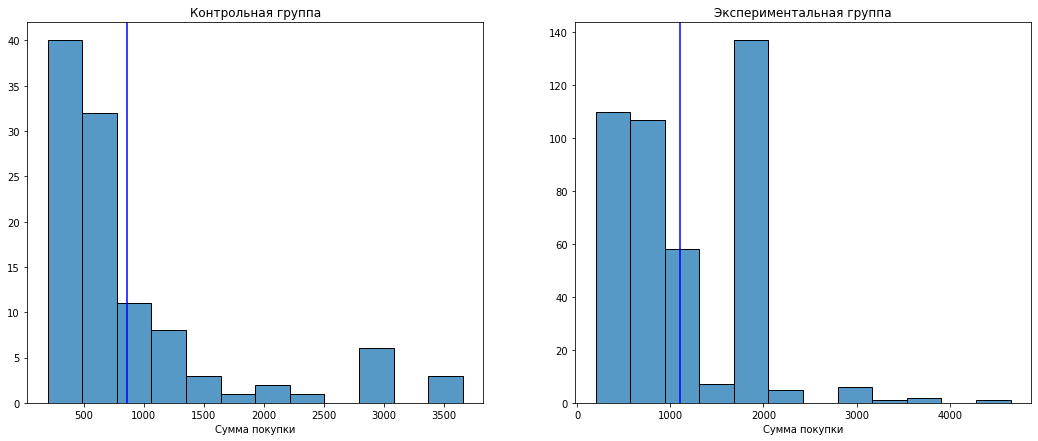

In [33]:
fig = plt.figure(figsize=(18, 7))
mean_a = np.mean(df_revenue_all.query("grp == 'A'").rev)
mean_b = np.mean(df_revenue_all.query("grp == 'B'").rev)
plt.subplot(1, 2, 1)
sns.histplot(data=df_revenue_all.query("grp == 'A'"), x='rev')
plt.axvline(mean_a, ymin=0, ymax=1, color='b')
plt.xlabel("Сумма покупки")
plt.title("Контрольная группа")
plt.ylabel("")

plt.subplot(1, 2, 2)
sns.histplot(data=df_revenue_all.query("grp == 'B'"),
             x='rev')
plt.axvline(mean_b, ymin=0, ymax=1, color='b')
plt.xlabel("Сумма покупки")
plt.title("Экспериментальная группа")
plt.ylabel("")


In [34]:
pg.normality(df_revenue_all, dv='rev', group='grp')

,W,pval,normal
B,0.867236,8.947893e-19,False
A,0.719612,5.321688e-13,False


In [35]:
pg.normality(df_revenue_all.query("~ (made_purchase == 1 and open_web == 0)"), 
             dv='rev', group='grp')

,W,pval,normal
B,0.854724,1.543702e-16,False
A,0.735324,1.498682e-10,False


In [36]:
df_revenue_all = df_revenue_all.query("~ (made_purchase == 1 and open_web == 0)")

### Выводы:
1. В группе **В** значительно больше пользователей (433 - пользователи, совершившие покупку, из них не заходили на сайт - 120, посетили веб-страницу - 314; 6 803 - зашли на сайт; 59 883 - всего), чем в **А** (107 - пользователи, совершившие покупку, из них: не заходили на сайт - 29, посетили веб-страницу - 78; 1538 - зашли на сайт; 14 693 - всего)
3. Распределение значения прибыли, которую приносит один пользователь, не является нормальным 
4. Есть студенты, которые в период проведения эксперимента не заходили на сайт, но они совершили покупку. Их нужно исключить из  экспериментальной группы, так как они явно не воспользовались сайтом для оплаты продукта. Предположу, что они совершили покупку не через сайт, а с помощью другого канала (через сайт банка, отдел продаж или транзакция проходила по рассрочке, которую взяли ранее)
5. Из таблицы df_revenue_all были исключены записи, где покупка была произведене, но пользователь не заходил на сайт.

### Метрики:
1. Выручка с 1 пользователя  
2. Конверсия (CR):
    - Абсолютная конверсия (CR в покупку) 
    $$CR = \frac{client}{user}$$
    - Относительная конверсия (СR пользователя, который заходил на сайт, в покупку)
    $$CR = \frac{client}{activ}$$
    где user - кол-во пользователей, user - кол-во пользователей, activ - кол-во активных пользователей
3. ARPPU (Average revenue per paying user)
$$ARPPU = \frac{rev}{client}$$
где rev - выручка, client - кол-во клиентов

4. ARPU (Average revenue per user)
$$ARPU = \frac{rev}{user}$$
где rev - выручка, user - кол-во пользователей
5. ARPAU (Average revenue per activ user)
$$ARPAU = \frac{rev}{activ}$$  
где rev - выручка, activ - кол-во активных пользователей   
Статистические методы:   
    - T-тест
    - хи-квадрат
    - Bootstrap

### 1. Выручка  
Проведем сравнение среднего значения выручки, которую приносит пользователь  
$H_0$ - средние значения равны в двух группах  
$H_1$ - средние значения не равны в двух группах  
$\alpha = 0,05$ 

In [37]:
df_group_A = df_revenue_all.query("grp == 'A'").rev.dropna()
df_group_B = df_revenue_all.query("grp == 'B'").rev.dropna()
pg.ttest(df_group_A, df_group_B)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.86169,106.981668,two-sided,0.00507,"[-548.94, -99.64]",0.39646,6.536,0.878211


Вывод: принимаем альтернативную гипотезу. В группе "B" среднее значение выручки статистически значимо больше чем в группе "А"

### 2. Конверсия 

$H_0 $ - конверсия не зависит от группы  
$H_1 $ - конверсия зависит от группы  
$\alpha = 0,05$

**Начнем с абсолютной конверсии (CR в покупку)**  
*Студентов, которые не зашли на сайт, но купили наш продукт, я исключу из итогового датасета*

In [38]:
df_CR = df_revenue_all\
    .groupby('grp', as_index=False)\
    .agg({'made_purchase':'sum', 'student_id':'count'})
df_CR['CR'] = df_CR.made_purchase / df_CR.student_id
df_CR

,grp,made_purchase,student_id,CR
0,A,78,14664,0.005319
1,B,314,59763,0.005254


In [39]:
expected, observed, stats = pg.chi2_independence(df_revenue_all, x='grp', y='made_purchase')
stats.round(3)

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000,0.001,1.0,0.973,0.0,0.05
1,cressie-read,0.667,0.001,1.0,0.973,0.0,0.05
2,log-likelihood,0.000,0.001,1.0,0.973,0.0,0.05
3,freeman-tukey,-0.500,0.001,1.0,0.973,0.0,0.05
4,mod-log-likelihood,-1.000,0.001,1.0,0.973,0.0,0.05
5,neyman,-2.000,0.001,1.0,0.973,0.0,0.05


Вывод: принимаем нулевую гипотезу. Абсолютная конверсия не зависит от группы 

**Посмотрим на относительную конверсию (СR пользователя, который заходил на сайт, в покупку)**

In [40]:
df_CR_open_web = df_revenue_all.query("open_web == 1")\
    .groupby('grp', as_index=False)\
    .agg({'made_purchase':'sum', 'student_id':'count'})
df_CR_open_web['CR_open_web'] = df_CR_open_web.made_purchase / df_CR_open_web.student_id
df_CR_open_web

,grp,made_purchase,student_id,CR_open_web
0,A,78,1538,0.050715
1,B,314,6803,0.046156


In [41]:
df_group_hi_test = df_revenue_all.query("open_web == 1")

In [42]:
expected, observed, stats = pg.chi2_independence(df_group_hi_test, x='grp', y='made_purchase')

In [43]:
stats.round(3)

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000,0.485,1.0,0.486,0.008,0.107
1,cressie-read,0.667,0.482,1.0,0.488,0.008,0.107
2,log-likelihood,0.000,0.477,1.0,0.490,0.008,0.106
3,freeman-tukey,-0.500,0.473,1.0,0.492,0.008,0.106
4,mod-log-likelihood,-1.000,0.469,1.0,0.494,0.007,0.105
5,neyman,-2.000,0.461,1.0,0.497,0.007,0.104


Вывод: принимаем нулевую гипотезу. Относительная конверсия (CR пользователя, который заходил на сайт, в покупку) не зависит от группы.

### Функция для проведения bootstrap

In [44]:
def do_bootstrap(sample_a, sample_b, n=1000, B=1000):
    """
    Для корректной работы программы:
        1. ARPU - заменить NaN на нули
        2. ARPPU - оставить только данные о платежах
        
    sample_a - значения из группы А
    sample_b - значения из группы В
    n=1000 - размер выборки, которую будем генерировать
    B=1000 - количество генерируемых подвыборок
    
    Этапы реализации функции бутстрапа:
    1. Взять исходные выборки и отобрать в бут-выборку наблюдения с повторением;
    2. Подсчитать метрику (посчитать общую прибыль и разделить на количество клиентов или );
    3. Повторить пункты 1-2 от 1000 до 5000 раз для получения эмпирического распределение статистики;
    4. Получить квантили alpha/2 и 1 - alpha/2
    5. Подсчитать p-value
    6. Визуализировать полученную выборку
    """

    alpha = 0.05
    stat_distrib = []
    
    # генерируем выборки и считаем статистику
    for i in range(B):
        bootstrap_values_a = np.random.choice(group_a, size=n, replace=True)
        bootstrap_values_b = np.random.choice(group_b, size=n, replace=True)
        stat_distrib.append((np.sum(bootstrap_values_a) - np.sum(bootstrap_values_b)) / n)
        
    p_value, ci = do_some_math(stat_distrib, alpha)
    do_some_viz(p_value, ci, stat_distrib)
    return p_value, ci, stat_distrib

def do_some_math(data, alpha):
    # подсчет доверительных интервалов
    left_q = alpha / 2
    right_q = 1 - left_q
    ci = np.quantile(data, [left_q, right_q])
    
    # p_value
    quant = ss.norm.cdf(x=0, loc=np.mean(data), scale=np.std(data, ddof=1))
    p_value = quant * 2 if 0 < np.mean(data) else (1 - quant) * 2
    return p_value, ci

def do_some_viz(p_value, ci, data):
    print(f'p-value: {p_value} \n')
    fig = plt.figure(figsize=(18, 7))
    s = pd.DataFrame({'val': data, 'col':['1' if x<=ci[0] or x>=ci[1] else '0' for x in data]})
    sns.histplot(s, x='val', hue='col', multiple="stack")
    pr = [0.025, 0.975]
    for i in range(len(ci)):
        plt.axvline(x=ci[i], ymin=0, ymax=0.5, linestyle='--', color='g',
                    label=f'CI({pr[i]}): {ci[i].round(3)}')
    plt.axvline(np.mean(data), ymin=0, ymax=1, color='b', 
                label=f'Statistic mean: {np.mean(data).round(3)}')
    plt.xlabel('statistic value', fontsize=14)
    plt.ylabel('frequency', fontsize=14)
    plt.legend(loc=0)
    

### 3. ARPU
$H_0$ - средние значения равны в двух группах  
$H_1$ - средние значения не равны в двух группах  
$\alpha = 0,05$ 

In [45]:
df_arpu = df_revenue_all\
    .groupby('grp', as_index=False)\
    .agg({'rev':'sum', 'student_id':'count'})
df_arpu['arpu'] = df_arpu.rev / df_arpu.student_id
df_arpu

,grp,rev,student_id,arpu
0,A,72820.0000,14664,4.965903
1,B,394974.0035,59763,6.609006


Bootstrap

p-value: 0.40801168283295763 



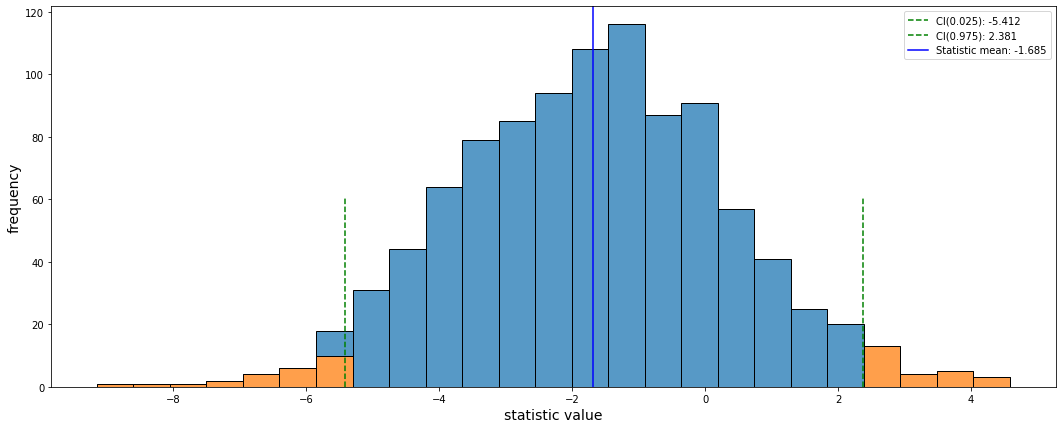

In [46]:
group_a = df_revenue_all.query("grp == 'A'").rev.fillna(0).values
group_b = df_revenue_all.query("grp == 'B'").rev.fillna(0).values

p_value, ci, data = do_bootstrap(group_a, group_b, n=5000)

Вывод: Принимаем нулевую гипотезу, средние значения ARPU равны в двух группах.

### 4. ARPPU
$H_0$ - средние значения равны в двух группах  
$H_1$ - средние значения не равны в двух группах  
$\alpha = 0,05$ 

In [47]:
df_revenue_all.head()

,student_id,grp,rev,open_web,made_purchase
0,1489,B,NaN,0,0
1,1627,A,990.0,1,1
2,1768,B,NaN,0,0
3,1783,B,NaN,0,0
4,1794,A,NaN,0,0


In [48]:
df_arppu = df_revenue_all\
    .groupby('grp', as_index=False)\
    .agg({'rev':'sum', 'made_purchase':'sum'})
df_arppu['arppu'] = df_arppu.rev / df_arppu.made_purchase
df_arppu

,grp,rev,made_purchase,arppu
0,A,72820.0000,78,933.589744
1,B,394974.0035,314,1257.878992


p-value: 0.0 



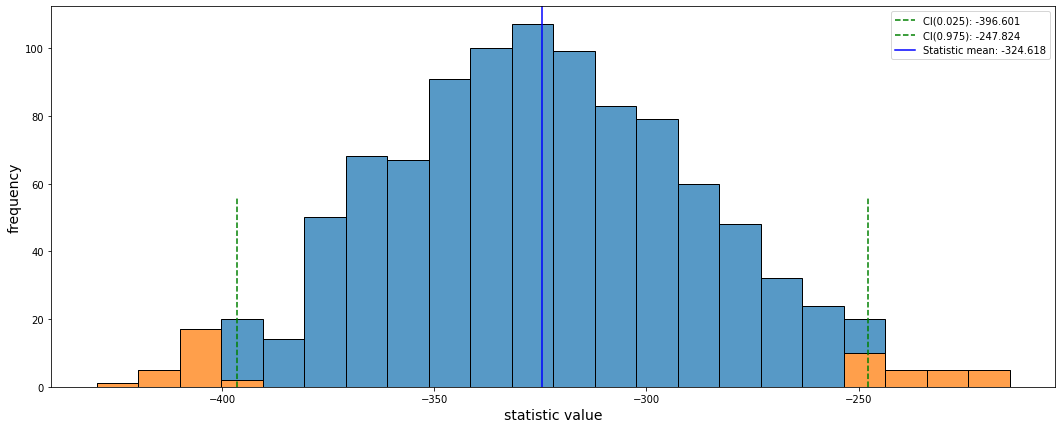

In [49]:
group_a = df_revenue_all.query("grp == 'A'").rev.dropna().values
group_b = df_revenue_all.query("grp == 'B'").rev.dropna().values

p_value, ci, data = do_bootstrap(group_a, group_b)

Вывод: принимаем альтернативную гипотезу, в группе B среднее значение ARPPU статистически значимо выше чем в группе А

### 5. ARPAU
$H_0$ - средние значения равны в двух группах  
$H_1$ - средние значения не равны в двух группах  
$\alpha = 0,05$ 

In [50]:
df_arpau = df_revenue_all\
    .groupby('grp', as_index=False)\
    .agg({'rev':'sum', 'open_web':'sum'})
df_arpau['arpau'] = df_arpau.rev / df_arpau.open_web
df_arpau

,grp,rev,open_web,arpau
0,A,72820.0000,1538,47.347204
1,B,394974.0035,6803,58.058798


p-value: 0.17461519899596611 



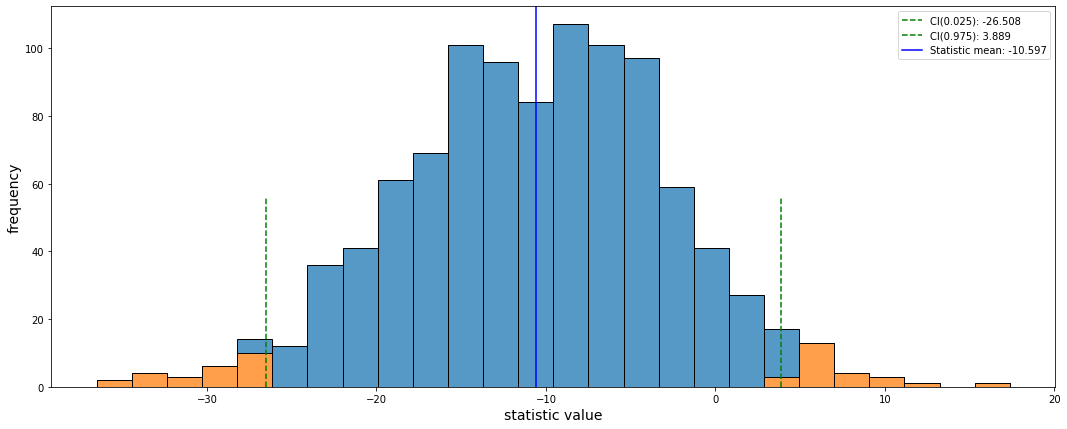

In [51]:
group_a = df_revenue_all.query("grp == 'A' and open_web == 1").rev.fillna(0).values
group_b = df_revenue_all.query("grp == 'B' and open_web == 1").rev.fillna(0).values

p_value, ci, data = do_bootstrap(group_a, group_b, n=3000)

Вывод: принимаем нулевую гипотезу. Среднее значение ARPAU равны в двух группах

###  Выводы:
1. Среднее значение выручки, которую приносит пользователь, в экспериментальной группе статистически больше по сравнению с контрольной. 
2. Не удалось выявить статистически значимое различие конверсий (абсолютной и относительной конверсий) между экспериментальной и контрольной группами. 
3. Средние значения ARPU и ARPAU равны в двух группах
4. В группе "B" среднее значение ARPPU статистически значимо выше чем в группе "А"

Необходимо вводить новую механику оплаты на сайте, так как она повлияла на основные метрики (средрее значение выручки и ARPPU)

## 2.1  Очень усердные ученики.

Написать оптимальный запрос, который даст информацию о количестве очень усердных студентов. (Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.)



In [52]:
diligent_students = '''
WITH current_month AS (
  SELECT
    toStartOfMonth(max(timest)) AS month
  FROM
    default.peas
)
SELECT
  count(st_id) as count_diligent_students
FROM
  (
    SELECT
      st_id,
      uniqExact(timest) AS item_count
    FROM
      default.peas,
      current_month
    WHERE
      timest >= current_month.month
      AND correct = 1
    GROUP BY
      st_id
    HAVING
      item_count >= 20
  ) 
  '''

Пояснение к запросу (как я пыталась сделать его оптимальным)
1. С помощью оператора WITH 1 раз посчитала дату начала месяца
2. В подзапросе:
    - Сравниваю дату с началом текущего месяца (timest >= current_month.month), а не высчитываю начало месяца у каждой строчки (toStartOfMonth(timest) = current_month.month)
    - Убрала в запросе метод uniqExact, id студентов уже уникальны из-за особенностей подзапроса (группировка по st_id)

In [53]:
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                  'database':'default',
                  'user':'student', 
                  'password':'dpo_python_2020'
                 }
df = ph.read_clickhouse(diligent_students,
                     connection=connection_default)

In [54]:
df

,count_diligent_students
0,136


## 2.2 Оптимизация воронки
Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

ARPU  
ARPAU  
CR в покупку  
СR активного пользователя в покупку  
CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике 
ARPU считается относительно всех пользователей, попавших в группы. 

In [55]:
optimization_funnel = '''
SELECT
  b.student_pay / a.all_stud as CTR,
  b.student_pay / c.activ_stud as activ_CTR,
  b.math_pay / c.activ_math as math_activ_CTR,
  b.rev / c.activ_stud as ARPAU,
  b.rev / a.all_stud as ARPU
FROM
  (
    -- Все студенты
    SELECT
      test_grp,
      uniqExact(st_id) AS all_stud
    FROM
      default.studs
    GROUP BY
      test_grp
  ) AS a
  JOIN (
    SELECT
      test_grp,
      SUM(money) AS rev,
      SUM(math_pay) AS math_pay,
      uniqExact(st_id) AS student_pay
    FROM(
        -- Студенты, которые оплатили курс, оплатили математику
        SELECT
          l.test_grp AS test_grp,
          r.subject AS subject,
          l.st_id AS st_id,
          r.money AS money,
          multiIf(
            (subject = 'Math')
            AND (money > 0),
            1,
            0
          ) AS math_pay
        FROM
          default.studs AS l
          JOIN default.final_project_check AS r ON l.st_id = r.st_id
      )
    GROUP BY
      test_grp
  ) AS b ON a.test_grp = b.test_grp
  JOIN (
    -- активные студенты по всем предметам
    SELECT 
       test_grp, 
       SUM(activ) AS activ_stud,
       SUM(activ_math) AS activ_math
    FROM
        (SELECT
            any(test_grp) AS test_grp,
            st_id,
            SUM(count_peas) AS all_count_peas,
            IF(all_count_peas >= 10, 1, 0) AS activ,
            MAX(activ_math) AS activ_math
        FROM
            (SELECT
                any(r.test_grp) AS test_grp,
                l.st_id AS st_id,
                l.subject AS subject,
                SUM(correct) AS count_peas,
                IF(count_peas >= 2 AND subject = 'Math', 1, 0) AS activ_math
            FROM
                default.peas AS l
                JOIN default.studs AS r ON r.st_id = l.st_id
            GROUP BY
                st_id,
                subject
            )
        GROUP BY
            st_id)
    GROUP BY
        test_grp
  ) as c ON b.test_grp = c.test_grp'''

In [56]:
df = ph.read_clickhouse(optimization_funnel,
                     connection=connection_default)

In [57]:
df.round(3)

,CTR,activ_CTR,math_activ_CTR,ARPAU,ARPU
0,0.049,0.114,0.163,10492.424,4540.984
1,0.108,0.317,0.381,33613.861,11508.475


### Задание 3. Python
3.1 Задача

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.  
Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [58]:
def merge_df(df_groups, df_groups_add, df_active_studs, df_checks):
    """
    Функция переименовывает колонки и создает общий датасет.
    В общий датафрейм не попадают данные о пользователях, которые оплатили курс, 
    но не заходили на сайт
    """
    new_col={'id':'student_id'}
    df_groups = df_groups.rename(columns=new_col)
    df_groups_add = df_groups_add.rename(columns=new_col)
    

    df_groups_all = df_groups.append(df_groups_add, ignore_index=True)
    df_active_studs['open_web'] = [1] * df_active_studs.shape[0]
    df_checks['made_purchase'] = [1] * df_checks.shape[0]
    result = df_groups_all.merge(df_active_studs, on='student_id', how='left')
    result = result.merge(df_checks, on='student_id', how='left')
    result = result.query("~ (made_purchase == 1 and open_web == 0)")
    return result

def count_metric(df):
    """
    Подсчет метрик:
    - CR
    - CR_activ
    - ARPU 
    - ARPAU
    - ARPPU
    """

    df_result = df.groupby('grp', as_index=False)\
    .agg({'rev': 'sum', 'open_web': 'sum', 'made_purchase': 'sum', 
          'student_id': 'count'})\
    .rename(columns= {'student_id': 'all_students'})

    df_result['CR'] = df_result.made_purchase / df_result.all_students
    df_result['CR_activ'] = df_result.made_purchase / df_result.open_web
    df_result['ARPU'] = df_result.rev / df_result.all_students
    df_result['ARPAU'] = df_result.rev / df_result.open_web
    df_result['ARPPU'] = df_result.rev / df_result.made_purchase
    return df_result

def get_basic_metrics():
    """
    Функция для автоматизации ad-hoc запросов.
    Выполняет: 
    1. Загрузку данных из файлов с использованием API; 
    2. Переименование заголовков;
    3. JOIN таблиц;
    4. Расчет основных метрик для контрольной и экспериментальной группы
    
    Возвращает таблицу с рассчитанными метриками
    """
    df_groups = read_yandex_disk('https://disk.yandex.ru/d/UhyYx41rTt3clQ', ';')
    df_groups_add = read_yandex_disk('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ')
    df_active_studs = read_yandex_disk('https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ')
    df_checks = read_yandex_disk('https://disk.yandex.ru/d/pH1q-VqcxXjsVA', ';')

    df_students = merge_df(df_groups, 
                           df_groups_add, 
                           df_active_studs, 
                           df_checks)
    df_metrics = count_metric(df_students)
    
    return df_metrics

In [60]:
def plot_graf(df_metrics):
    """
    Функция строит графики по данным, которые были получены после завершения работы функции get_basic_metrics()
    """
    
    col_metrics = df_metrics.columns
    fig = plt.figure(figsize=(20, 10))
    for i in range(1, len(col_metrics)):
        plt.subplot(3, 3, i)
        sns.barplot(x='grp', y=col_metrics[i], data=df_metrics)
        plt.subplots_adjust(wspace=0.3, hspace=0.5)
        plt.ylabel(col_metrics[i]) 
        #plt.xlabel(col_metrics[i])

In [59]:
df_metrics = get_basic_metrics()
df_metrics

,grp,rev,open_web,made_purchase,all_students,CR,CR_activ,ARPU,ARPAU,ARPPU
0,A,92096.0000,1538.0,107.0,14693,0.007282,0.069571,6.268019,59.880364,860.710280
1,B,481230.0036,6803.0,434.0,59883,0.007247,0.063795,8.036171,70.737910,1108.824893


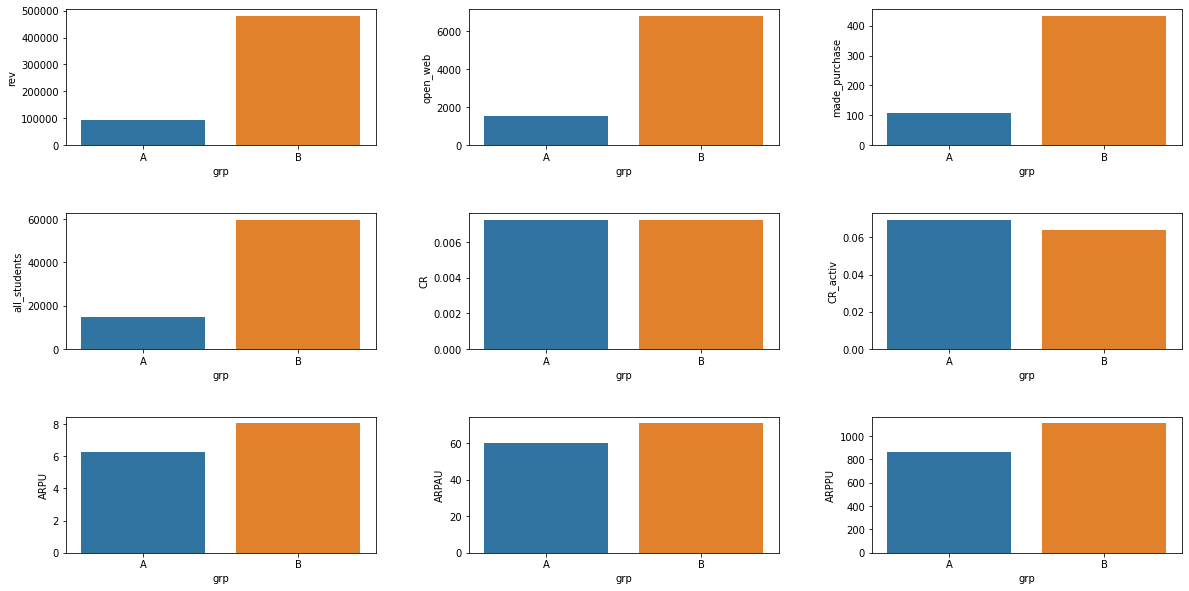

In [61]:
plot_graf(df_metrics)

### Общие выводы:
1.1. Среднее значение выручки, которую приносит пользователь, в экспериментальной группе статистически больше по сравнению с контрольной. 
1.2. Не удалось выявить статистически значимое различие конверсий (абсолютной и относительной конверсий) между экспериментальной и контрольной группами.  
1.3. Средние значения ARPU и ARPAU равны в двух группах  
1.4. В группе "B" среднее значение ARPPU статистически значимо выше чем в группе "А"  

1.5. Необходимо вводить новую механику оплаты на сайте, так как она повлияла на основные метрики (средрее значение выручки и ARPPU)  


2.1 Было выявлено 136 усердных учеников, у которых 20 и более решенных горошин в месяц  
2.2 Из базы данных были выведены следующие метрики:
- ARPU
- ARPAU
- CR в покупку
- СR активного пользователя в покупку
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике ARPU считается относительно всех пользователей, попавших в группы.   

3.1 Написана функция для автоматизации ad-hoc запросов  
3.2 Реализована функция для построения графиков  